In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statistics
import torch
import sys
import glob
import os
import cv2
import time
import math

from PIL import Image
from scipy.ndimage import binary_fill_holes

In [2]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [3]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/home/wsl/bin/segment-anything/checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"

# device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

/home/wsl/bin/anaconda3/envs/sam-2/lib/python3.11/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color="green", marker=".", s=marker_size, edgecolor="black", linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color="red", marker=".", s=marker_size, edgecolor="black", linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0,0,0,0), lw=2))    

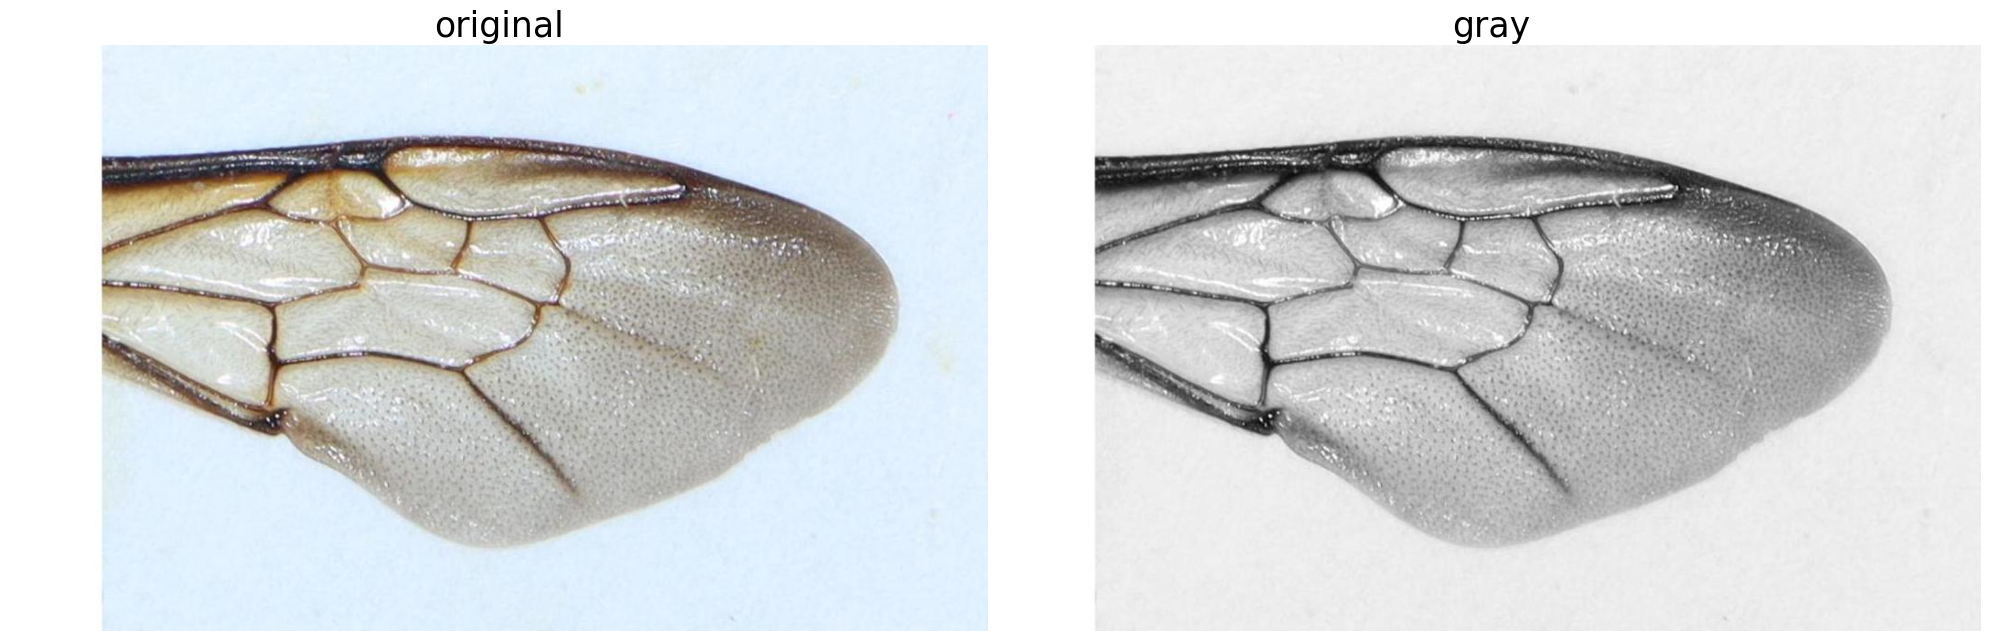

In [5]:
test_1 = "/mnt/c/Projects/Master/Data/Processed/3-LiveWingWingRemovedBackground/Round01-Hive01-2024_06_11-h01b23.JPG"
test_2 = "/mnt/c/Projects/Master/Data/Processed/3-LiveWingWingRemovedBackground/Round01-Hive01-2024_06_27-h01b26.JPG"
test_3 = "/mnt/c/Projects/Master/Data/Processed/3-LiveWingWingRemovedBackground/Round01-Hive02-2024_06_10-h02b32.JPG"
test_4 = "/mnt/c/Projects/Master/Data/Processed/3-LiveWingWingRemovedBackground/Round01-Hive03-2024_06_14-h03b47.JPG"

test_5 = "/mnt/c/Projects/Master/Temporary/14-11-2024/4-LiveWingWingsImproved/h21b02.JPG"

# Load image
image = cv2.imread(test_5)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Create a 1x2 figure
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
# Image 1
axes[0].imshow(image)
axes[0].axis("off")
axes[0].set_title("original", size=25)

# Grayscale image
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Image 1
axes[1].imshow(gray, cmap="gray")
axes[1].axis("off")
axes[1].set_title("gray", size=25)

# Show the figure
plt.tight_layout()
plt.show()

blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

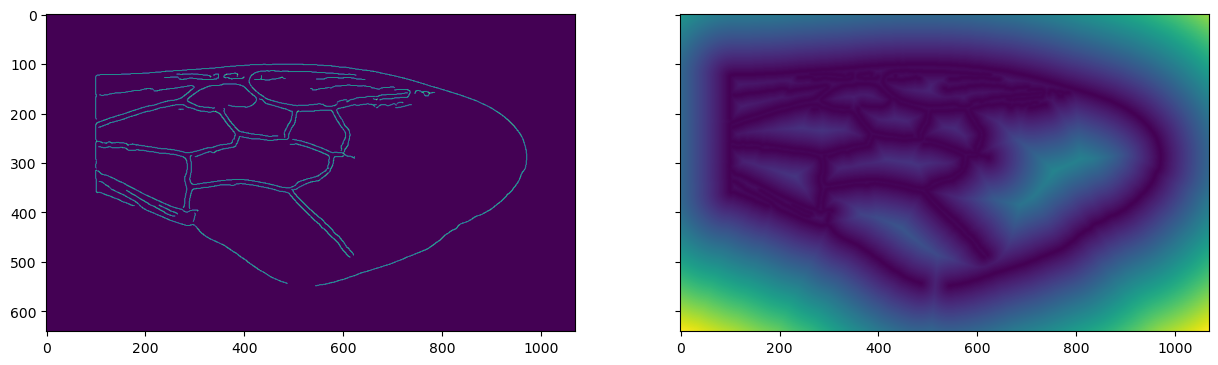

In [6]:
from scipy.ndimage import distance_transform_edt
from skimage.feature import canny

edges = canny(gray, sigma=3.5)
dt = distance_transform_edt(~edges)

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharex=True, sharey=True)
ax0.imshow(edges)
ax1.imshow(dt)

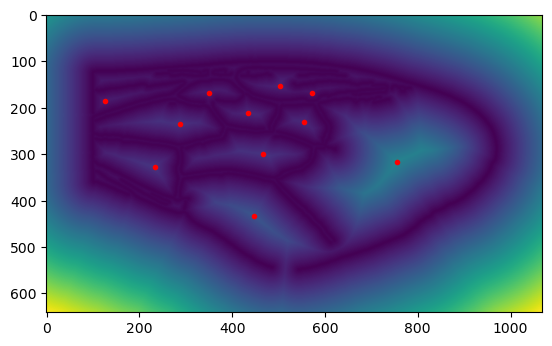

In [7]:
from skimage.feature import peak_local_max

local_max = peak_local_max(dt, min_distance=40)

plt.imshow(dt, cmap='viridis')
plt.plot(local_max[:, 1], local_max[:, 0], 'r.')

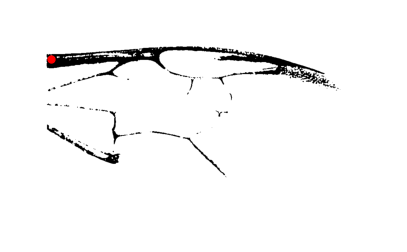

In [36]:
def find_black_area(image, window_size):
    h, w = image.shape
    max_density = -1
    best_coords = (0, 0)

    # Slide the window over the image
    for y in range(0, h - window_size[1] + 1, 1):
        for x in range(0, w - window_size[0] + 1, 1):
            # Extract the window from the image
            window = image[y:y + window_size[1], x:x + window_size[0]]

            # Count the number of black pixels (assuming black pixels are 0)
            black_pixel_count = np.sum(window == 0)

            # Track the window with the maximum number of black pixels
            if black_pixel_count > max_density:
                max_density = black_pixel_count
                best_coords = (x, y)

    return best_coords

# Apply Gaussian Blur
blurred_image = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply thresholding to get a binary image
_, thresh = cv2.threshold(blurred_image, 100, 255, cv2.THRESH_BINARY)

window_size = (20, 20)
cords = find_black_area(thresh, window_size)

plt.figure(figsize=(5, 5))
plt.imshow(thresh, cmap="gray")
plt.scatter(cords[0], cords[1], c="red", s=100, marker=".")
plt.axis("off")
plt.show()

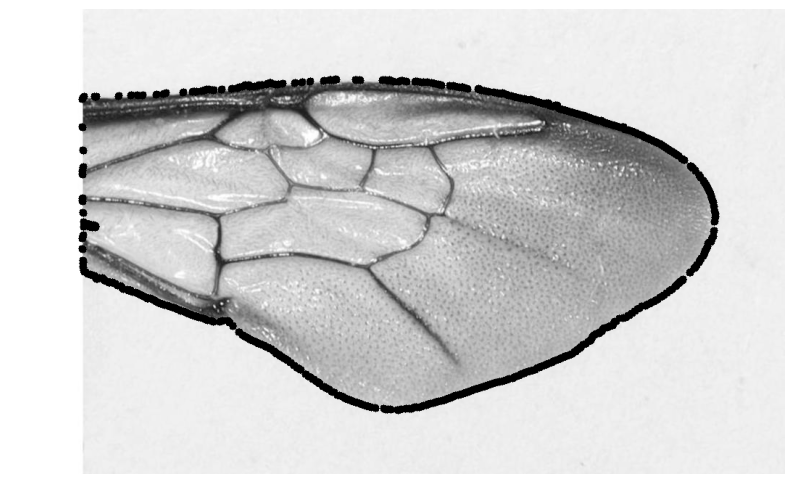

In [30]:
blurred_image = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply thresholding to get a binary image
_, wing_thresh = cv2.threshold(blurred_image, 225, 255, cv2.THRESH_BINARY)

# Invert the binary image
wing_inv_thresh = cv2.bitwise_not(wing_thresh)

# Find contour
all_wing_contours, _ = cv2.findContours(wing_inv_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize variables to track the largest contour
largest_contour = None
largest_area = 0

# Iterate through all contours to find the largest
for contour in all_wing_contours:
    area = cv2.contourArea(contour)
    if area > largest_area:
        largest_area = area
        largest_contour = contour
        
# Calculate wing area
wing_area = cv2.contourArea(largest_contour)

wing_contour_image = gray.copy()
cv2.drawContours(wing_contour_image, largest_contour, -1, (0), 10)

plt.figure(figsize=(10, 10))
plt.imshow(wing_contour_image, cmap="gray")
plt.axis("off")
plt.show() 


Best threshold: 191
  Number of segments: 11
  Percentage of area covered: 13.39%
  Centroids: [(517, 535), (445, 415), (585, 355), (433, 301), (552, 239), (256, 236), (670, 229), (430, 217), (595, 164), (478, 165), (395, 167)]


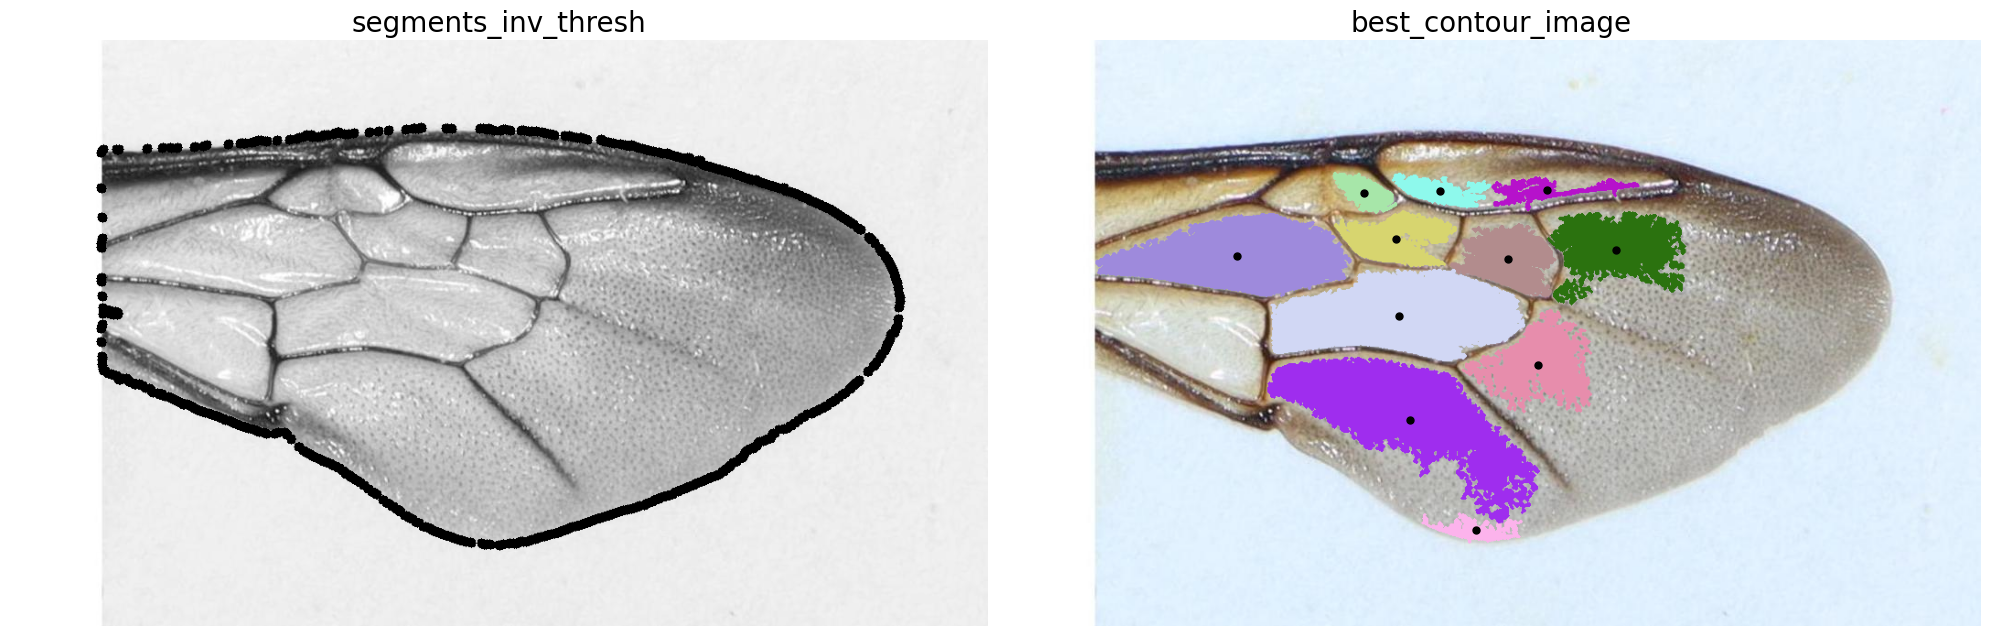

Resulting list structure:
[(517, 535), (445, 415), (585, 355), (433, 301), (552, 239), (670, 229), (430, 217), (595, 164), (478, 165), (395, 167)]


TypeError: 'int' object is not iterable

In [40]:
def distance_to_bottom_right(coord, bottom_right):
    return math.sqrt((coord[0] - bottom_right[0])**2 + (coord[1] - bottom_right[1])**2)
    

def find_black_area(image, window_size):
    h, w = image.shape
    max_density = -1
    best_coords = (0, 0)

    # Slide the window over the image
    for y in range(0, h - window_size[1] + 1, 1):
        for x in range(0, w - window_size[0] + 1, 1):
            # Extract the window from the image
            window = image[y:y + window_size[1], x:x + window_size[0]]

            # Count the number of black pixels (assuming black pixels are 0)
            black_pixel_count = np.sum(window == 0)

            # Track the window with the maximum number of black pixels
            if black_pixel_count > max_density:
                max_density = black_pixel_count
                best_coords = (x, y)

    return best_coords
    

def segmentation(gray, image):
    """
    # Apply Gaussian Blur
    blurred_image = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply thresholding to get a binary image
    _, wing_thresh = cv2.threshold(blurred_image, 250, 255, cv2.THRESH_BINARY)

    # Invert the binary image
    wing_inv_thresh = cv2.bitwise_not(wing_thresh)

    # Find contour
    all_wing_contours, _ = cv2.findContours(wing_inv_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate wing area
    wing_area = sum(cv2.contourArea(contour) for contour in all_wing_contours)
    
    wing_contour_image = gray.copy()
    cv2.drawContours(wing_contour_image, all_wing_contours, -1, (0), 10)
    """
    
    blurred_image = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply thresholding to get a binary image
    _, wing_thresh = cv2.threshold(blurred_image, 225, 255, cv2.THRESH_BINARY)
    
    # Invert the binary image
    wing_inv_thresh = cv2.bitwise_not(wing_thresh)
    
    # Find contour
    all_wing_contours, _ = cv2.findContours(wing_inv_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Initialize variables to track the largest contour
    largest_contour = None
    largest_area = 0
    
    # Iterate through all contours to find the largest
    for contour in all_wing_contours:
        area = cv2.contourArea(contour)
        if area > largest_area:
            largest_area = area
            largest_contour = contour
            
    # Calculate wing area
    wing_area = cv2.contourArea(largest_contour)
    
    wing_contour_image = gray.copy()
    cv2.drawContours(wing_contour_image, largest_contour, -1, (0), 10)

    """
    plt.figure(figsize=(20, 20))
    plt.imshow(wing_contour_image, cmap="gray")
    plt.axis("off")
    plt.show() 
    """
    # Initialize variables to track the best image
    max_contours = 0
    best_percentage_covered = 0
    best_centroids = []
    best_contour_image = None
    best_threshold = None

    threshold = 250
    while threshold >= 0:
        # Apply thresholding to get a binary image
        _, segments_thresh = cv2.threshold(wing_contour_image, threshold, 255, cv2.THRESH_BINARY)
    
        # Invert the binary image
        segments_inv_thresh = cv2.bitwise_not(segments_thresh)
        
        # Find contour
        # all_segments_contours, _ = cv2.findContours(segments_inv_thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
        # Find contours with RETR_TREE to get hierarchy
        all_segments_contours, hierarchy = cv2.findContours(segments_inv_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
        # Filter only internal contours
        internal_contours = [all_segments_contours[i] for i in range(len(all_segments_contours)) if hierarchy[0][i][3] != -1]

        # Filter out small contours
        large_segment_contours = [cnt for cnt in internal_contours if (cv2.contourArea(cnt) > 1000)]

        if len(large_segment_contours) > 0:
            # Initialize total area and centroids
            total_area = 0
            centroids = []
    
            # Create a copy of the image for drawing
            segments_contour_image = image.copy()
    
            # Process each contour
            for contour in large_segment_contours:
                # Calculate area
                contour_area = cv2.contourArea(contour)
                total_area += contour_area
    
                # Calculate centroid
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                    centroids.append((cx, cy))
    
                    # Draw a small circle at the center
                    # cv2.circle(segments_contour_image, (cx, cy), radius=5, color=(0, 0, 0), thickness=-1)
    
                # Draw the contour
                color = (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256))
                cv2.drawContours(segments_contour_image, [contour], -1, color, thickness=cv2.FILLED)
    
            # Calculate percentage covered
            wing_area = gray.shape[0] * gray.shape[1]
            percentage_covered = (total_area / wing_area) * 100
    
            # print(f"  Number of segments: {len(large_segment_contours)}")
            # print(f"  Percentage of area covered: {percentage_covered:.2f}%")
    
            # Update the best image based on criteria
            if (len(large_segment_contours) > max_contours) or (len(large_segment_contours) == max_contours and percentage_covered > best_percentage_covered):
                best_threshold = threshold
                max_contours = len(large_segment_contours)
                best_percentage_covered = percentage_covered
                best_centroids = centroids
                best_contour_image = segments_contour_image

        # Decrease threshold until 0 is reached 
        threshold -= 1

    # Output the results for the best image
    print(f"\nBest threshold: {best_threshold}")
    print(f"  Number of segments: {max_contours}")
    print(f"  Percentage of area covered: {best_percentage_covered:.2f}%")
    print(f"  Centroids: {best_centroids}")

    # Extract X and Y coordinates of centroids
    centroid_x = [cx for cx, cy in best_centroids]
    centroid_y = [cy for cx, cy in best_centroids]

    # Create a 1x2 figure
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    # Image 1
    axes[0].imshow(wing_contour_image, cmap="gray")
    axes[0].axis("off")
    axes[0].set_title(f"segments_inv_thresh", size=20)
    # Image 2
    axes[1].imshow(best_contour_image)
    axes[1].scatter(centroid_x, centroid_y, c="black", s=100, marker=".")
    axes[1].set_title(f"best_contour_image", size=20)
    axes[1].axis("off")

    # Show the figure
    plt.tight_layout()
    plt.show()
    plt.close()

    if len(best_centroids) > 1:
        # Apply thresholding to get a binary image
        _, thresh = cv2.threshold(blurred_image, 100, 255, cv2.THRESH_BINARY)
        
        window_size = (20, 20)
        black_cord = find_black_area(thresh, window_size)

        # Find the point with the smallest x-coordinate
        left_cord = min(best_centroids, key=lambda point: point[0])
        
        # Split the list
        coordinates = [cord for cord in best_centroids if cord != left_cord]
        """
        # Number of bottom-right coordinates to select
        x = 3

        # Example image dimensions (height, width)
        image_shape = image.shape
        
        # Coordinates of the bottom-right corner
        bottom_right_cords = (image_shape[1], image_shape[0])
    
        
        # Sort the coordinates by distance to the bottom-right corner
        sorted_coordinates = sorted(coordinates, key=lambda coord: distance_to_bottom_right(coord, bottom_right_cords))

        # Split the list
        bottom_right = sorted_coordinates[:x]  # Top `x` coordinates
        cords = [[coord] for coord in sorted_coordinates[x:]]  # Individual lists for each remaining coordinate
        
        # Append the bottom-right list as the last element
        cords.append(bottom_right)
        """
        print("Resulting list structure:")
        print(coordinates)

        best_segment_masks = []
        
        for cord in coordinates:
            # Start by adding excluded coordinates (with label 0)
            input_points = np.array([list(black_cord), list(left_cord)] + [list(c) for c in cord])
            input_labels = np.array([0, 0] + [1] * len(cord))
    
            predictor.set_image(image)
    
            masks, scores, _ = predictor.predict(
            point_coords=input_points,
            point_labels=input_labels,
            multimask_output=False,
            )
            plt.figure(figsize=(10, 10))
            plt.imshow(image)
            show_mask(masks, plt.gca())
            show_points(input_points, input_labels, plt.gca())
            plt.axis("off")
            plt.show() 
            best_segment_masks.append(masks[0])

        combined_masks = np.zeros((best_segment_masks[0].shape[0], best_segment_masks[0].shape[1], 4))  # 4 channels for RGBA
        
        # Loop through masks and add their color to the combined_image
        for i, mask in enumerate(best_segment_masks):
            color = (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256))
            for c in range(3):  # Apply the color to each channel (R, G, B)
                combined_masks[:, :, c] += mask * color[i][c]

        # Set alpha (transparency) channel: 1 where there's a mask, 0 (transparent) where there's no mask
        combined_masks[:, :, 3] = np.sum(best_segment_masks, axis=0)  # Alpha = 1 where any mask is present
        combined_masks[:, :, 3] = np.clip(combined_masks[:, :, 3], 0, 1)  # Ensure alpha stays between 0 and 1
        
        # Clip the RGB values to ensure they're within [0, 1] range
        combined_masks[:, :, :3] = np.clip(combined_masks[:, :, :3], 0, 1)
        
        # Show Image
        plt.figure(figsize=(20, 20))
        plt.imshow(image)
        plt.imshow(combined_masks, alpha=0.6)
        plt.axis("off")
        plt.show()  
        
segmentation(gray, image)

In [38]:
len([(517, 535), (445, 415), (585, 355), (433, 301), (552, 239), (670, 229), (430, 217), (595, 164), (478, 165), (395, 167)])

10

In [39]:
[0, 0] + [1] * 9

[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Processing file 001/189:	Round01-Hive01-2024_06_05-h01bee01.JPG

Best threshold: 75
  Number of segments: 12
  Percentage of area covered: 9.71%
  Centroids: [(169, 414), (266, 410), (414, 408), (564, 346), (597, 301), (442, 324), (354, 277), (421, 244), (378, 214), (525, 239), (638, 208), (482, 176)]


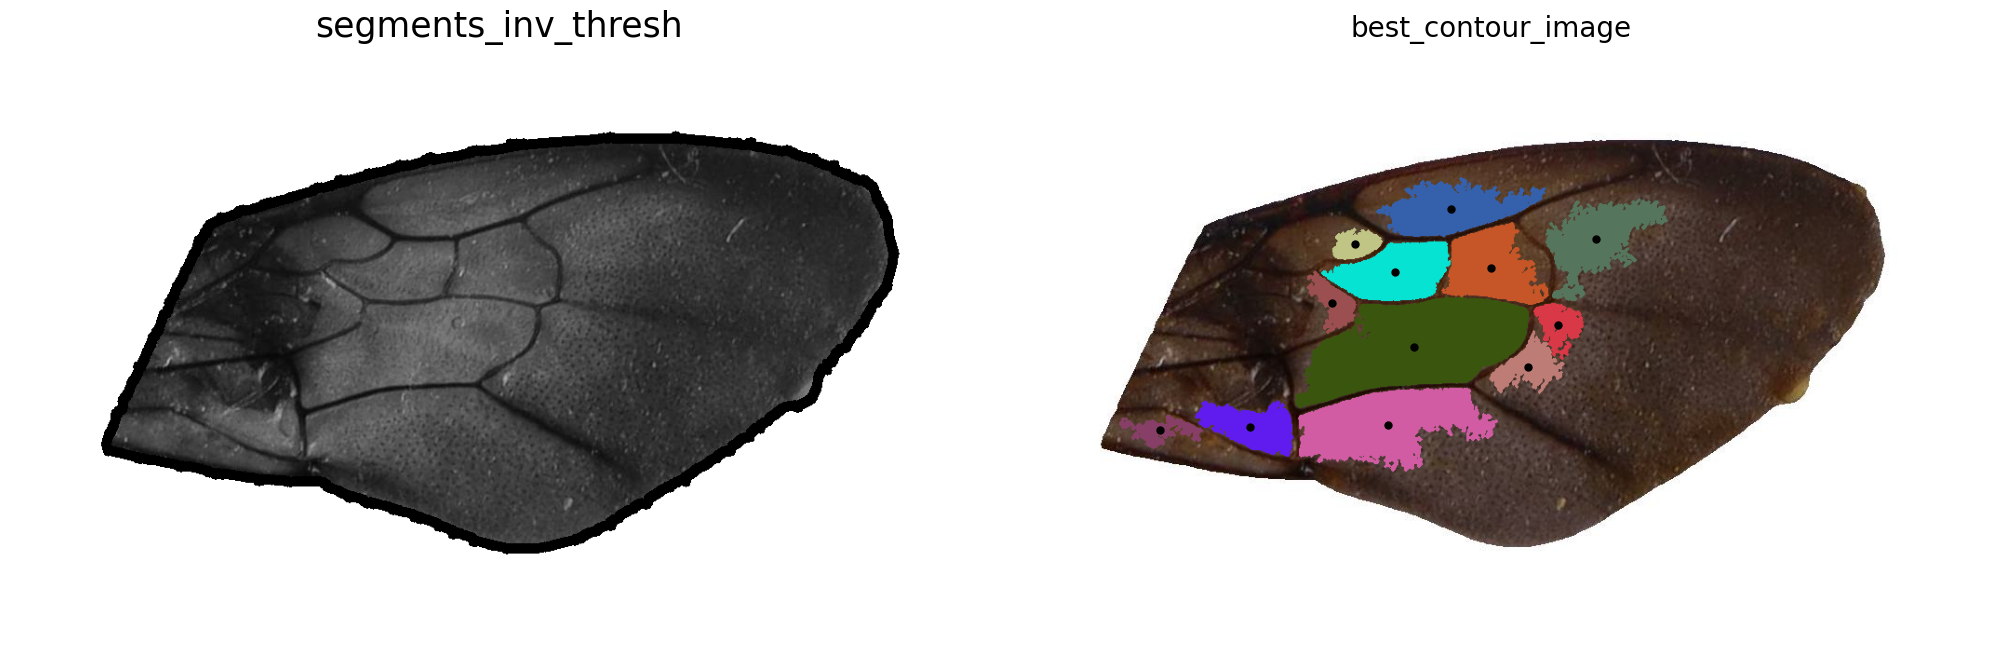

KeyboardInterrupt: 

In [40]:
# Define directories
input_dir = "/mnt/c/Projects/Master/Data/Processed/3-LiveWingWingRemovedBackground_1/"
output_dir = "/mnt/c/Projects/Master/Data/Testdata/4-LiveWingSegmented/"

# Find all jpg files
jpg_files = []
for root, _, files in os.walk(input_dir):
    for file in files:
        if file.endswith(".JPG") or file.endswith(".jpg"):
            jpg_files.append(os.path.join(root, file))

# Create output directory
os.makedirs(output_dir, exist_ok=True)

# Process every file
total_files = len(jpg_files)
digits = len(str(total_files))
for idx, jpg_file_path in enumerate(jpg_files, 1):
    jpg_basename = os.path.basename(jpg_file_path)
    output_file = output_dir + jpg_basename
    relative_jpg_path = jpg_file_path.removeprefix(input_dir)
    print(f"Processing file {idx:0{digits}}/{total_files}:\t{relative_jpg_path}")
    
    # Load image
    image = cv2.imread(jpg_file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Grayscale image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    segmentation(gray, image)

In [15]:
# List of coordinates
coordinates = [
    (189, 464), (513, 453), (236, 413), (669, 370), (633, 382),
    (444, 335), (267, 323), (161, 303), (677, 267), (426, 256)
]

# Number of bottom-right coordinates to select
x = 3

# Sort coordinates based on x and y values in descending order
sorted_coordinates = sorted(coordinates, key=lambda coord: (coord[0], coord[1]), reverse=True)

# Split the list
bottom_right = sorted_coordinates[:x]  # Top `x` coordinates
cords = [[coord] for coord in sorted_coordinates[x:]]  # Individual lists for each remaining coordinate

# Append the bottom-right list as the last element
cords.append(bottom_right)

print("Resulting list structure:")
print(cords)


Resulting list structure:
[[(513, 453)], [(444, 335)], [(426, 256)], [(267, 323)], [(236, 413)], [(189, 464)], [(161, 303)], [(677, 267), (669, 370), (633, 382)]]


In [35]:
black_cord = [1, 1]
left_cord = [0, 0]

for cord in cords:
    input_points = np.array([black_cord] + [left_cord] + cord)
    input_labels = np.array([0, 0] + [1] * len(cord))

    print(input_points)
    print(input_labels)

[[  1   1]
 [  0   0]
 [513 453]]
[0 0 1]
[[  1   1]
 [  0   0]
 [444 335]]
[0 0 1]
[[  1   1]
 [  0   0]
 [426 256]]
[0 0 1]
[[  1   1]
 [  0   0]
 [267 323]]
[0 0 1]
[[  1   1]
 [  0   0]
 [236 413]]
[0 0 1]
[[  1   1]
 [  0   0]
 [189 464]]
[0 0 1]
[[  1   1]
 [  0   0]
 [161 303]]
[0 0 1]
[[  1   1]
 [  0   0]
 [677 267]
 [669 370]
 [633 382]]
[0 0 1 1 1]


In [42]:
bottom_right = image.shape[:2]

(643, 1051)

In [43]:
def distance_to_bottom_right(coord, bottom_right_cords):
    return math.sqrt((coord[0] - bottom_right_cords[0])**2 + (coord[1] - bottom_right_cords[1])**2)

# Coordinates of bottom right corner
bottom_right_cords = image.shape[:2]

# Sort the coordinates by distance to the bottom-right corner
sorted_coordinates = sorted(coordinates, key=distance_to_bottom_right)